# Import the essential libraries

# Aim

My aim is not to generate a highly accurate model but to demonstrate how to use the ResNet50 architecture for image classification. Please note that the model was trained for only 3 epochs due to computer constraints. I recommend running the model for 100 epochs and experimenting with different parameters to achieve better accuracy and performance.

Running the model for a larger number of epochs allows the model to learn more complex patterns and improve its performance over time. It gives the model more opportunities to converge and optimize its weights based on the training data.

## Explanation of the model ResNet 50 model

### Please note that each RestNet 50 model has 3 default blocks. So I copied them from the following source and used my own parameters. 
https://github.com/y33-j3T/Coursera-Deep-Learning/blob/master/Convolutional%20Neural%20Networks/week2/ResNets/Residual_Networks_v2a.ipynb

1. Identity Block:
The identity_block function is a building block used in the ResNet architecture. It aims to preserve the identity of the input tensor while learning additional features. Here's a breakdown of the identity_block function:

Arguments:
    input_tensor: The input tensor to the identity block.
    kernel_size: The size of the kernel used in the convolutional layers.
    filters: A list of three integers representing the number of filters in the three convolutional layers.
    stage: An integer representing the stage or position of the identity block in the network.
    block: A string representing the block's position within the stage.

2. Convolutional Block:
The convolutional_block function is another building block used in the ResNet architecture. It includes a convolutional layer with a shortcut connection to downsample the input and increase the number of filters. Here's an explanation of the convolutional_block function:

Arguments:
    input_tensor: The input tensor to the convolutional block.
    kernel_size: The size of the kernel used in the convolutional layers.
    filters: A list of three integers representing the number of filters in the three convolutional layers.
    stage: An integer representing the stage or position of the convolutional block in the network.
    block: A string representing the block's position within the stage.
    strides: A tuple of two integers representing the stride used in the first convolutional layer.
    
3. ResNet50
The ResNet50 function builds the ResNet-50 model by combining the identity blocks and convolutional blocks. It provides the complete architecture for the ResNet-50 model. Here's a breakdown of the ResNet50 function.

Arguments:
    input_shape: A tuple specifying the shape of the input images.
    num_classes: The number of classes in the classification task.


In [3]:
# Essential and common packages
import os
import glob

# Plots and bars
import matplotlib.pyplot as plt
#https://github.com/amanchadha/coursera-deep-learning-specialization/blob/master/C4%20-%20Convolutional%20Neural%20Networks/Week%202/ResNets/Residual_Networks.ipynb
# Computation library
import numpy as np

# Tensorflow for building the resnet50 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

# Sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# For visualization of plots without plt.show()
%matplotlib inline

In [4]:
tf.__version__

'2.12.0'

# Define the required variable

In [7]:
primaryPath='C:/Studies/Copernicus Program/1_Semester 2/Software development practice/Assignment 3'
dataset_url = primaryPath+'/2750'
modelSavePath = primaryPath+'/EuroSAT/model'
batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255
print(dataset_url)

C:/Studies/Copernicus Program/1_Semester 2/Software development practice/Assignment 3/2750


# Data preparation for the model

In [8]:
"""
The validation_split parameter in the ImageDataGenerator constructor indicates the fraction of the 
dataset that should be reserved for validation during training
"""
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)

"""
create a tf.data.Dataset object directly from the directory structure containing image files.
"""
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [5]:
# Generate train dataset batches of augmented image data from a directory structure.
"""
subset="training" indicates that the generator will generate batches from the training subset of the dataset
class_mode='categorical' means that the labels will be encoded categorical vectors.
shuffle= If set to True, the order of the images within each batch will be randomly shuffled during training.
target_size: Sets the desired dimensions to which the input images will be resized. 
batch_size: Determines the number of samples processed in each training iteration.
"""

train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [14]:
# Generate validation dataset batches of augmented image data from a directory structure.
"""
subset="training" indicates that the generator will generate batches from the training subset of the dataset
class_mode='categorical' means that the labels will be encoded categorical vectors.
shuffle= If set to True, the order of the images within each batch will be randomly shuffled during training.
target_size: Sets the desired dimensions to which the input images will be resized. 
batch_size: Determines the number of samples processed in each training iteration.
"""
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


# Visualization of input datasets

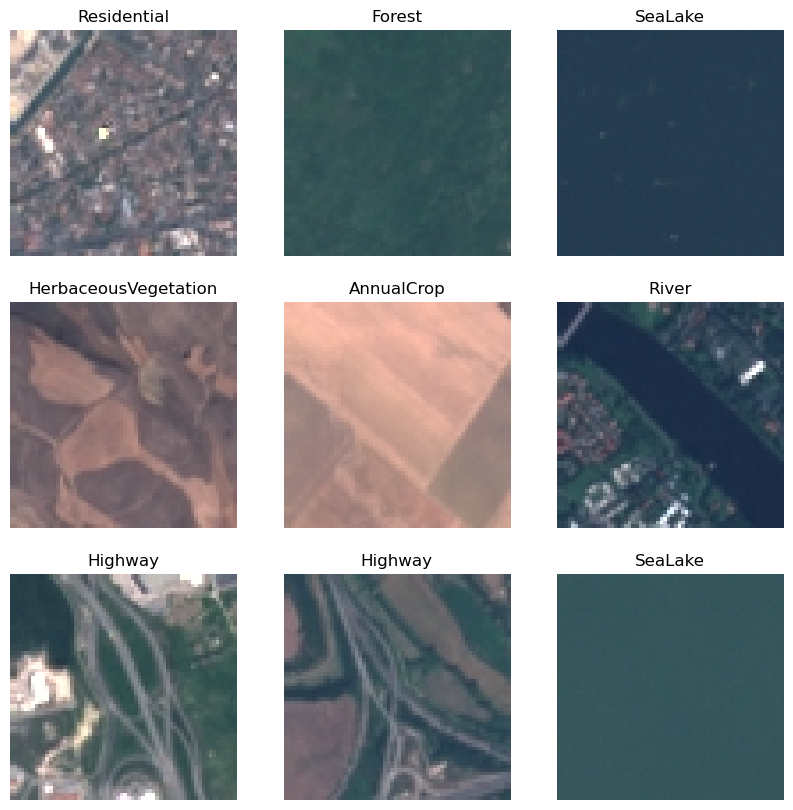

In [7]:
"""
dataset.class_names attribute is used to retrieve the list of class names in a dataset generated by 
tf.keras.preprocessing.image_dataset_from_directory.
"""
class_names = dataset.class_names

# visualize a subset of images from a dataset
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# ResNet50 Model building

In [8]:
"""
The identity_block function in the ResNet architecture is a building block that is used to construct deeper 
networks while preserving the input size and feature map dimensions. It helps in mitigating the degradation 
problem that can occur when deep networks are trained.

source
https://github.com/y33-j3T/Coursera-Deep-Learning/blob/master/Convolutional%20Neural%20Networks/week2/ResNets/Residual_Networks_v2a.ipynb
"""



def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [9]:
"""
The convolutional_block function in the ResNet architecture is another building block that is used to construct 
deeper networks while down-sampling the input size and increasing the number of feature maps. It helps in capturing 
more complex and abstract features as the network goes deeper.

source
https://github.com/y33-j3T/Coursera-Deep-Learning/blob/master/Convolutional%20Neural%20Networks/week2/ResNets/Residual_Networks_v2a.ipynb
"""


def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [10]:
"""
The ResNet50 function defines the ResNet-50 model architecture. It consists of a series of convolutional blocks and 
identity blocks, which are repeated to create the deep network. The function takes the input_shape and num_classes as 
arguments and returns a Keras Model object representing the ResNet-50 model.

source
https://github.com/y33-j3T/Coursera-Deep-Learning/blob/master/Convolutional%20Neural%20Networks/week2/ResNets/Residual_Networks_v2a.ipynb
"""


def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

# Model train

In [11]:
model = ResNet50(input_shape=(64,64,3), classes=10) # Create a ResNet50 model with the specified input shape and number of classes
model.summary() # Print a summary of the model architecture

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                   

 conv2d_10 (Conv2D)             (None, 15, 15, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 15, 15, 256)  1024       ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_2 (Add)                    (None, 15, 15, 256)  0           ['activation_6[0][0]',           
                                                                  'batch_normalization_10[0][0]'] 
                                                                                                  
 activation_9 (Activation)      (None, 15, 15, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 conv2d_11

                                                                  'batch_normalization_20[0][0]'] 
                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 512)    0           ['add_5[0][0]']                  
                                                                                                  
 conv2d_21 (Conv2D)             (None, 8, 8, 128)    65664       ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_21 (BatchN  (None, 8, 8, 128)   512         ['conv2d_21[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 8, 8, 128)    0           ['batch_normalization_21[0][0]'] 
          

 batch_normalization_31 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_31[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_28 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_31[0][0]'] 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_28[0][0]']          
                                                                                                  
 batch_normalization_32 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_32[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_42 (Conv2D)             (None, 4, 4, 1024)   263168      ['activation_38[0][0]']          
                                                                                                  
 batch_normalization_42 (BatchN  (None, 4, 4, 1024)  4096        ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_12 (Add)                   (None, 4, 4, 1024)   0           ['activation_36[0][0]',          
                                                                  'batch_normalization_42[0][0]'] 
                                                                                                  
 activation_39 (Activation)     (None, 4, 4, 1024)   0           ['add_12[0][0]']                 
          

 add_15 (Add)                   (None, 2, 2, 2048)   0           ['activation_45[0][0]',          
                                                                  'batch_normalization_52[0][0]'] 
                                                                                                  
 activation_48 (Activation)     (None, 2, 2, 2048)   0           ['add_15[0][0]']                 
                                                                                                  
 avg_pool (AveragePooling2D)    (None, 1, 1, 2048)   0           ['activation_48[0][0]']          
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['avg_pool[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 10)           20490       ['flatten[0][0]']                
          

In [12]:
"""
The model.compile function in TensorFlow/Keras is used to configure the learning process of a neural network model. 
It specifies the optimizer, loss function, and evaluation metrics to be used during model training.

optimizer: Specifies the optimizer algorithm to be used for updating the model weights based on the computed gradients during 
backpropagation. In this case, 'adam' is used as the optimizer, which refers to the Adam optimization algorithm. 

loss: Specifies the loss function to be optimized during training.  It measures the dissimilarity between the true labels and 
the predicted probabilities, aiming to minimize this dissimilarity during training.

metrics: Specifies the evaluation metrics to be computed and reported during training and evaluation. Here, ['accuracy'] is used
as the metric, which calculates the accuracy of the model predictions compared to the true labels.

"""

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# please increase the epoch for higher accuracy (epochs=100)

"""
The model.fit function in TensorFlow/Keras is used to train a neural network model on a given dataset. It iteratively trains 
the model for a specified number of epochs, updating the model's parameters based on the provided training data.

train_dataset: The training dataset to be used for training the model.

validation_data: The optional validation dataset used to evaluate the model's performance on unseen data during training. 
It should be in the same format as the train_dataset. The model's performance on this validation dataset is computed and 
reported after each epoch, allowing you to monitor the model's progress and detect overfitting.

epochs: The number of times the model will iterate over the entire training dataset during training. Each epoch represents 
one complete pass through the training data.

batch_size: The number of samples from the training dataset that will be used to compute one update of the model's parameters. 
The training data is divided into batches, and the model's weights are updated after each batch. Smaller batch sizes typically lead to more frequent weight updates but may require more time for training.

"""
history = model.fit(train_dataset, validation_data=test_dataset, epochs=4, batch_size=32)

Epoch 1/4
675/675 [==============================] - 4091s 6s/step - loss: 1.5865 - accuracy: 0.5165 - val_loss: 1.0857 - val_accuracy: 0.6307
Epoch 2/4
675/675 [==============================] - 3925s 6s/step - loss: 0.9209 - accuracy: 0.6853 - val_loss: 1.3466 - val_accuracy: 0.5874
Epoch 3/4
675/675 [==============================] - 3920s 6s/step - loss: 0.8001 - accuracy: 0.7394 - val_loss: 0.7618 - val_accuracy: 0.7674
Epoch 4/4
675/675 [==============================] - 3941s 6s/step - loss: 0.7684 - accuracy: 0.7608 - val_loss: 2.9377 - val_accuracy: 0.4728


In [16]:
# Save the model

model.save(modelSavePath+'/model_3_epoch.h5')

# Load model

In [17]:
#Load the model 
from tensorflow.keras.models import load_model
model = load_model(modelSavePath+'/model_3_epoch.h5')

# analyzing results and visualization

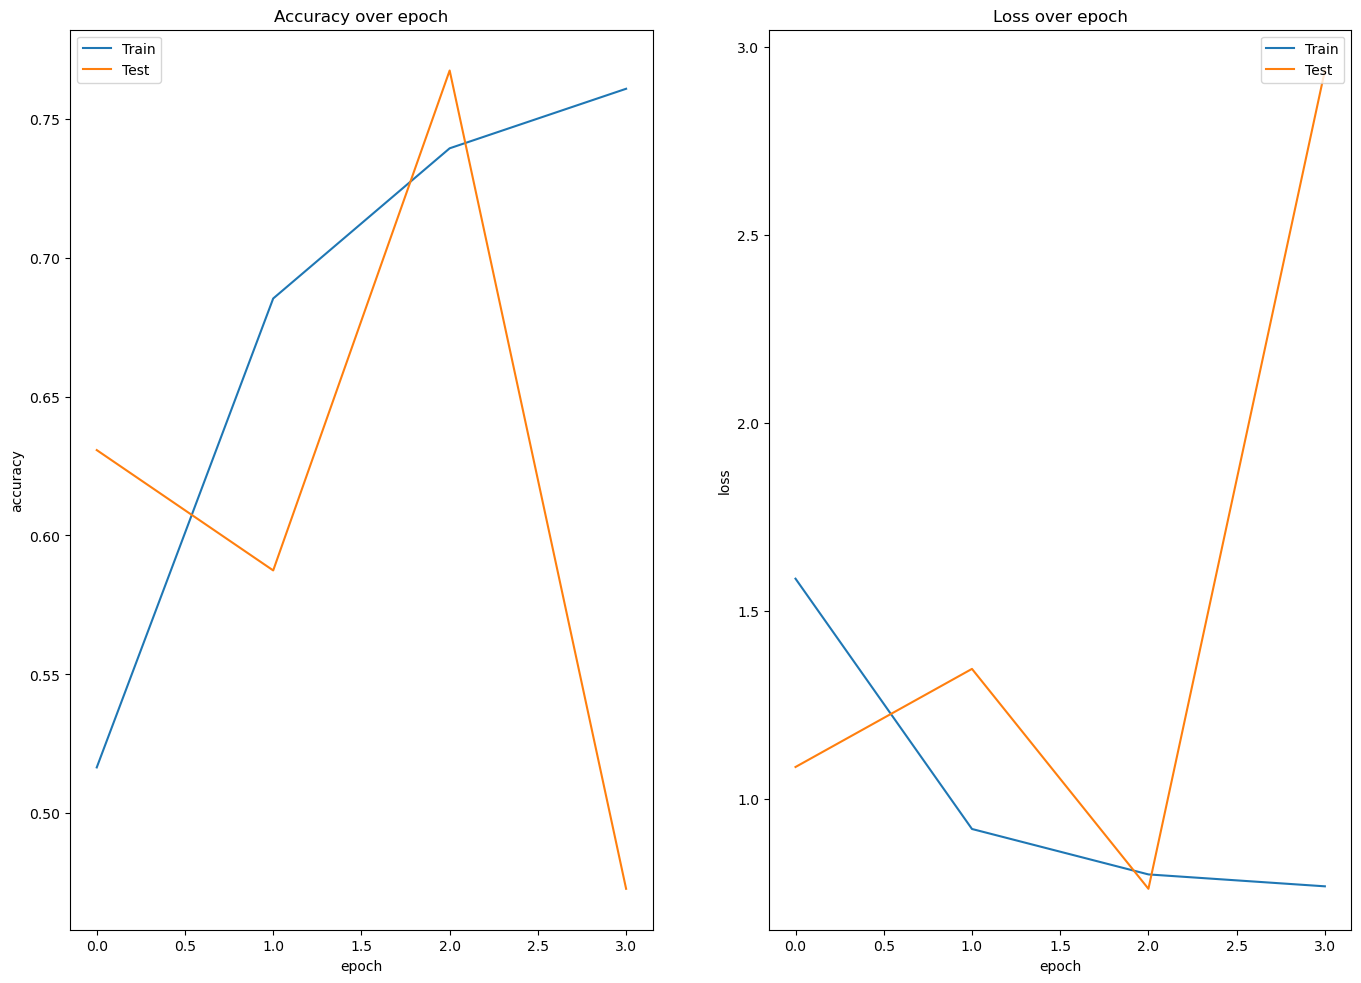

In [18]:
"""
The provided code snippet is plotting the training and validation accuracy as well as the training and validation loss 
over the epochs using Matplotlib

This code creates a figure with two subplots side by side. In the first subplot, the accuracy values are plotted, while 
the second subplot shows the loss values. The plot visualizes the changes in accuracy and loss over the epochs for both 
the training and validation datasets, providing insights into the model's performance and potential overfitting.

"""


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

# Confusion matrix

In [19]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

"""
The provided code snippet is performing inference on a test dataset using a trained model and collecting the predicted labels 
and true labels for evaluation purposes.
"""


"""
The code iterates over the test_dataset to process each batch of images and their corresponding labels. It appends the true 
labels (label_batch) to the y_true list.

Then, it uses the trained model (model) to predict the labels for the current batch of images (image_batch) using 
model.predict(). 

The predicted labels are obtained by taking the argmax along the predicted probabilities axis (np.argmax(preds, axis=1)), 
and they are appended to the y_pred list. 
"""
# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors

"""
The true labels stored in y_true are concatenated along the specified axis (0) using tf.concat() to obtain a single tensor 
(correct_labels). 

Then, np.argmax() is used to convert the true labels to their corresponding class.

Similarly, the predicted labels stored in y_pred are concatenated using tf.concat() to obtain a single tensor (predicted_labels).

"""

correct_labels = tf.concat([item for item in y_true], axis = 0) # Concatenate the true labels along the specified axis
correct_labels = np.argmax(correct_labels, axis=1) # Convert the true labels to class indices
predicted_labels = tf.concat([item for item in y_pred], axis = 0) # Concatenate the predicted labels along the specified axis

1/1 [==============================] - 1s 816ms/step


In [23]:
"""
The confusion_matrix function is a useful tool for evaluating the performance of a classification model. In this CNN I have used
this function to evaluate the performance of the model
"""
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[504,  84, 102,   4,   9,  59, 211,  72,  15,   9],
       [ 25,  96,  87,   6,   0,  26,   0,   5,   5, 817],
       [ 44,  23, 422,  25,  50,  33, 119, 284,  46,  13],
       [101,  10,  22, 205,  98,  40,  77,  85, 240,   3],
       [ 56,   4,   0,  15, 799,   2,   1,   7,  11,   0],
       [ 54, 166,  67,   3,   1, 316,  24,  14,  30,  44],
       [155,   5,  88,  23,  40,  42, 437,  86,  13,   0],
       [ 10,   1,   3,  71, 311,  36,  30, 602,  12,   0],
       [ 98,  33,  16,  58,  20, 139,  15,  21, 472,  14],
       [ 11, 185,  35,   0,   1, 106,   5,  18,   8, 714]], dtype=int64)

In [24]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize) # Create a new figure with the specified figure size
    plt.imshow(cm, interpolation='nearest', cmap=cmap) # Display the confusion matrix with the specified colormap
    plt.title(title) # Set the title of the confusion matrix plot
    plt.colorbar() # Add a colorbar to the plot
    tick_marks = np.arange(len(classes)) # Generate an array of tick positions
    plt.xticks(tick_marks, classes, rotation=45) # Set the x-axis tick positions and labels with rotation
    plt.yticks(tick_marks, classes) # Set the y-axis tick positions and labels

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix
        print("Normalized confusion matrix") # Print a message indicating that the confusion matrix is normalized
    else:
        print('Confusion matrix, without normalization') # Print a message indicating that the confusion matrix is not normalized

    print(cm)
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[504  84 102   4   9  59 211  72  15   9]
 [ 25  96  87   6   0  26   0   5   5 817]
 [ 44  23 422  25  50  33 119 284  46  13]
 [101  10  22 205  98  40  77  85 240   3]
 [ 56   4   0  15 799   2   1   7  11   0]
 [ 54 166  67   3   1 316  24  14  30  44]
 [155   5  88  23  40  42 437  86  13   0]
 [ 10   1   3  71 311  36  30 602  12   0]
 [ 98  33  16  58  20 139  15  21 472  14]
 [ 11 185  35   0   1 106   5  18   8 714]]


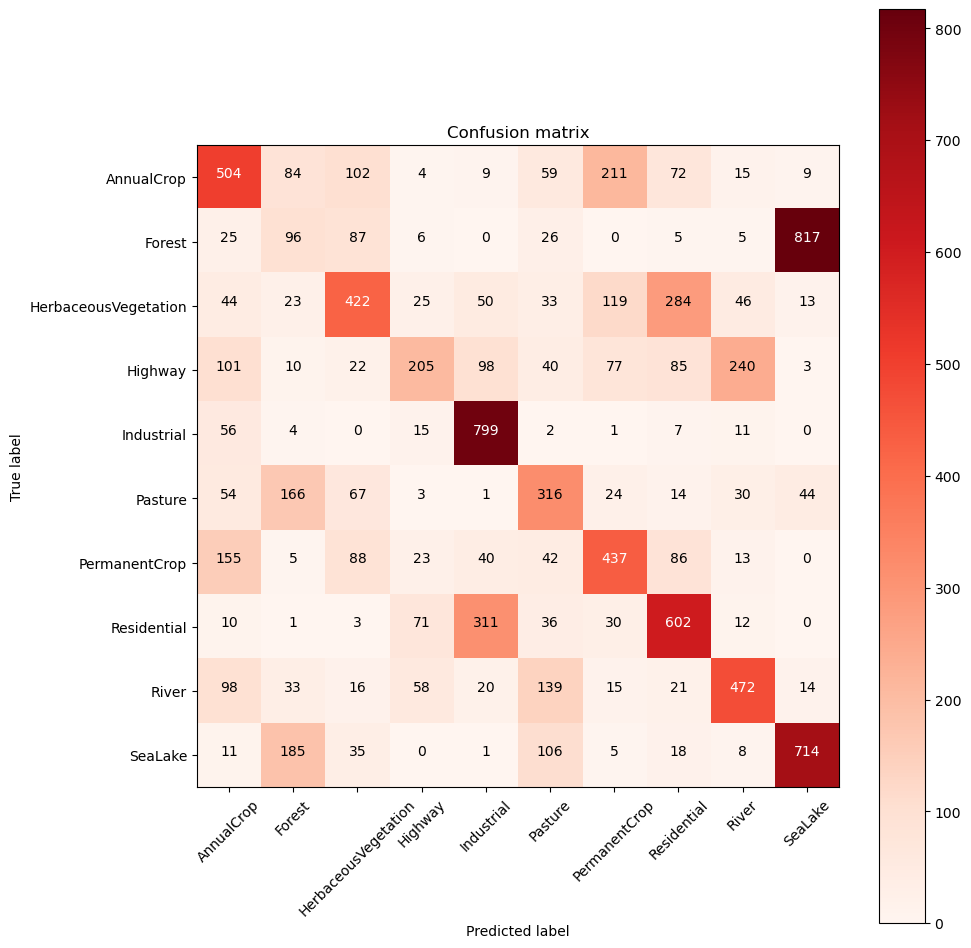

In [25]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')